# Transport emission

In [6]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import json

In [7]:
# constants
DATA_PATH = '../data/'
TRANSPORT_DATA_PATH = DATA_PATH + 'transport/'
GENERATED_DATA_PATH = '../generated/'

# Merges all datasets

In order to calculate the real emission of countries, we need to take into account the transport cost of all imported food. Eurostat (European Statistical Office) has a database containing all traded goods of EU countries, labeled by mode of transport. From this, we are able to calculate the emission, given the distance between two countries. The data can be found here: https://ec.europa.eu/eurostat/web/international-trade-in-goods/data/database

In [30]:
# The data had to be queried in 22 different files, otherwise the Eurostat database crashes.
datasets = [f"{TRANSPORT_DATA_PATH}transport ({i}).csv" for i in range(1,21)]

In [31]:
# Merge all the datasets
transport_merge = pd.DataFrame()
for dataset in datasets:
    transport_merge = transport_merge.append(pd.read_csv(dataset))

In [42]:
transport_merge

,REPORTER,PARTNER,PRODUCT,FLOW,TRANSPORT_MODE,PERIOD,QUANTITY_IN_TONS
0,FRANCE,NEW CALEDONIA,AGRICULTURAL PRODUCTS AND LIVE ANIMALS,IMPORT,Sea,Jan.-Dec. 1999,0
1,FRANCE,FRENCH POLYNESIA,AGRICULTURAL PRODUCTS AND LIVE ANIMALS,IMPORT,Sea,Jan.-Dec. 1999,0
2,FRANCE,NETHERLANDS ANTILLES (incl. ARUBA->1986),AGRICULTURAL PRODUCTS AND LIVE ANIMALS,IMPORT,Sea,Jan.-Dec. 2000,0
3,FRANCE,FRENCH POLYNESIA,AGRICULTURAL PRODUCTS AND LIVE ANIMALS,IMPORT,Sea,Jan.-Dec. 2000,0
4,FRANCE,PANAMA (excl. CANAL ->1980),AGRICULTURAL PRODUCTS AND LIVE ANIMALS,IMPORT,Sea,Jan.-Dec. 2001,0
...,...,...,...,...,...,...,...
11274,SLOVENIA,EU28_EXTRA,FOODSTUFFS AND ANIMAL FODDER,IMPORT,Sea,Jan.-Dec. 2015,951756
11275,SLOVENIA,EU28_EXTRA,FOODSTUFFS AND ANIMAL FODDER,IMPORT,Sea,Jan.-Dec. 2009,966728
11276,SLOVENIA,EU28_EXTRA,FOODSTUFFS AND ANIMAL FODDER,IMPORT,Sea,Jan.-Dec. 2011,1093896
11277,SLOVENIA,EU28_EXTRA,FOODSTUFFS AND ANIMAL FODDER,IMPORT,Sea,Jan.-Dec. 2010,1217845


In [47]:
transport_merge['PRODUCT'].unique()

array(['AGRICULTURAL PRODUCTS AND LIVE ANIMALS',
       'FOODSTUFFS AND ANIMAL FODDER', 'TOTAL'], dtype=object)

In [56]:
def clean_data(df):
    """
    Drop unnecessary columns, delete 0 rows, clean up the years.
    """
    df = df.drop(columns=['FLOW'])
    # Make year pretty
    df['PERIOD'] = df['PERIOD'].apply(lambda x: x.split(' ')[1])
    
    # Total is only present in some datasets, so drop
    df = df[df['PRODUCT'] != "TOTAL"]
    df = df[df['QUANTITY_IN_TONS'] != 0]
    df = df.drop(columns=['PRODUCT'])
    return df

In [62]:
transport = clean_data(transport_merge)
# Sum the two types of product (AGRICULTURAL PRODUCTS AND LIVE ANIMALS','FOODSTUFFS AND ANIMAL FODDER)
transport = transport.groupby(by=['PARTNER', 'REPORTER', 'TRANSPORT_MODE', 'PERIOD']).agg('sum').reset_index()

In [63]:
transport['REPORTER'].unique()

array(['AUSTRIA', 'BELGIUM (and LUXBG -> 1998)', 'BULGARIA', 'CROATIA',
       'CYPRUS', 'CZECHIA (CS->1992)', 'DENMARK', 'ESTONIA', 'FINLAND',
       'FRANCE', 'GERMANY (incl DD from 1991)', 'GREECE', 'HUNGARY',
       'IRELAND', 'ITALY', 'LATVIA', 'LITHUANIA', 'MALTA', 'NETHERLANDS',
       'POLAND', 'PORTUGAL', 'ROMANIA', 'SLOVAKIA', 'SLOVENIA', 'SPAIN',
       'SWEDEN', 'UNITED KINGDOM', 'LUXEMBOURG'], dtype=object)

In [64]:
# Load the distances between every country, dataset found here: http://www.cepii.fr/cepii/en/bdd_modele/presentation.asp?id=6
distances = pd.read_excel(TRANSPORT_DATA_PATH+'dist_cepii.xls') 
distances

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
0,ABW,ABW,0,0,0,0,0,0,0,0,5.225315,5.225315,25.0935,23.0472
1,ABW,AFG,0,0,0,0,0,0,0,0,13257.810000,13257.810000,13168.2,13166.4
2,ABW,AGO,0,0,0,0,0,0,0,0,9516.913000,9516.913000,9587.32,9584.19
3,ABW,AIA,0,0,1,0,0,0,0,0,983.268200,983.268200,976.897,976.892
4,ABW,ALB,0,0,0,0,0,0,0,0,9091.742000,9091.742000,9091.58,9091.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,ZWE,YUG,0,0,0,0,0,0,0,0,7056.402000,7056.402000,7046.43,7042.83
50172,ZWE,ZAF,1,1,1,0,0,0,0,0,2186.206000,926.174300,1258.55,1101.44
50173,ZWE,ZAR,0,0,0,0,0,0,0,0,2283.061000,2283.061000,1930.98,1719.15
50174,ZWE,ZMB,1,1,1,0,1,0,0,0,396.804100,396.804100,583.795,525.073


We need to link this to the transport data, for this we need the full country name. Luckily the GeoDist data also provides this

In [65]:
# Database containing countries and their iso3 codes
countries = pd.read_excel(TRANSPORT_DATA_PATH+'geo_cepii.xls') 
countries

,iso2,iso3,cnum,country,pays,area,dis_int,landlocked,continent,city_en,...,lang9_2,lang9_3,lang9_4,colonizer1,colonizer2,colonizer3,colonizer4,short_colonizer1,short_colonizer2,short_colonizer3
0,AW,ABW,533,Aruba,Aruba,193,5.225315,0,America,Oranjestad,...,.,.,.,NLD,.,.,.,.,.,.
1,AF,AFG,4,Afghanistan,Afghanistan,652225,303.761400,1,Asia,Kabul,...,Uzbek,.,.,.,.,.,.,GBR,.,.
2,AO,AGO,24,Angola,Angola,1246700,419.966600,0,Africa,Luanda,...,.,.,.,PRT,.,.,.,.,.,.
3,AI,AIA,660,Anguilla,Anguilla,102,3.798690,0,America,The Valley,...,.,.,.,GBR,.,.,.,.,.,.
4,AL,ALB,8,Albania,Albanie,28748,63.773110,0,Europe,Tirana,...,.,.,.,TUR,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,ZA,ZAF,711,South Africa,Afrique du Sud,1219912,415.430200,0,Africa,Pretoria,...,Shoto,.,.,GBR,NLD,.,.,.,.,.
234,ZA,ZAF,711,South Africa,Afrique du Sud,1219912,415.430200,0,Africa,Cape Town,...,Shoto,.,.,GBR,NLD,.,.,.,.,.
235,ZR,ZAR,180,Congo (Democratic Republic of the),"Congo, Rép. dém. du",2345410,576.027500,0,Africa,Kinshasa,...,Luba-Kasai,French,.,BEL,.,.,.,.,.,.
236,ZM,ZMB,894,Zambia,Zambie,752614,326.302200,1,Africa,Lusaka,...,Tonga,.,.,GBR,.,.,.,.,.,.


In [66]:
# iso3 codes of all european countries
european_iso3 = ['AUT', 'BEL', 'BGR', 'HRV', 'CYP', 'CZE', 'DNK', 'EST', 'FIN', 'FRA', 'DEU', 'GRC', 'HUN', 'IRL', 'ITA', 'LVA', 'LTU', 'LUX', 'MLT', 'NLD', 'POL', 'PRT', 'ROU', 'SVK', 'SVN', 'ESP', 'SWE', 'GBR']

In [67]:
# Drop unecessary columns
countries = countries[['iso3','country']]
# Only keep eu countries
distances = distances[distances['iso_o'].isin(european_iso3)]
# iso of origin, destination and distance
distances = distances[['iso_o','iso_d','distcap']]

In [68]:
total_distances = distances.merge(countries,left_on='iso_d',right_on='iso3')
total_distances = total_distances.merge(countries,left_on='iso_o',right_on='iso3')
total_distances = total_distances[['country_x','country_y','distcap']]
total_distances

,country_x,country_y,distcap
0,Aruba,Austria,8719.1300
1,Afghanistan,Austria,4568.0980
2,Angola,Austria,6357.0170
3,Anguilla,Austria,7742.3590
4,Albania,Austria,812.9326
...,...,...,...
6631,South Africa,Sweden,9513.3720
6632,South Africa,Sweden,9513.3720
6633,Congo (Democratic Republic of the),Sweden,7086.6070
6634,Zambia,Sweden,8376.2960


Now we can merge the distances and transport dataset, by country. Unfortunately, the country formats are a bit different, so we will first have to clean this

In [69]:
total_distances['country_x'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'Netherland Antilles', 'United Arab Emirates', 'Argentina',
       'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium and Luxembourg', 'Benin',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China',
       "Côte d'Ivoire", 'Cameroon', 'Congo', 'Cook Islands', 'Colombia',
       'Comoros', 'Cape Verde', 'Costa Rica', 'Cuba', 'Christmas Island',
       'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany',
       'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria',
       'Ecuador', 'Egypt', 'Eritrea', 'Western Sahara', 'Spain',
       'Estonia', 'Ethiopia', 'Finland', 'Fi

In [70]:
transport['REPORTER'].unique()

array(['AUSTRIA', 'BELGIUM (and LUXBG -> 1998)', 'BULGARIA', 'CROATIA',
       'CYPRUS', 'CZECHIA (CS->1992)', 'DENMARK', 'ESTONIA', 'FINLAND',
       'FRANCE', 'GERMANY (incl DD from 1991)', 'GREECE', 'HUNGARY',
       'IRELAND', 'ITALY', 'LATVIA', 'LITHUANIA', 'MALTA', 'NETHERLANDS',
       'POLAND', 'PORTUGAL', 'ROMANIA', 'SLOVAKIA', 'SLOVENIA', 'SPAIN',
       'SWEDEN', 'UNITED KINGDOM', 'LUXEMBOURG'], dtype=object)

In [71]:
def clean_countries(series):
    # Clean everything between brackets and remove trailing whitespaces
    new_series = series.apply(lambda x: x.split('(')[0].strip())
    # Remove everything after comma
    new_series = new_series.apply(lambda x: x.split(',')[0].strip().lower())
    return new_series

In [73]:
total_distances_clean = total_distances
total_distances_clean['country_x'] = clean_countries(total_distances_clean['country_x'])
total_distances_clean['country_y'] = clean_countries(total_distances_clean['country_y'])

transport_clean = transport
transport_clean['PARTNER'] = clean_countries(transport_clean['PARTNER'])
transport_clean['REPORTER'] = clean_countries(transport_clean['REPORTER'])

In [74]:
dist_countries = set(total_distances_clean['country_x'])
trans_countries = set(transport_clean['PARTNER'])
countries_int = dist_countries.intersection(trans_countries)
print(f"The amount of countries in both datasets is {len(countries_int)}")

The amount of countries in both datasets is 185


In [75]:
# The countries in the transport dataset that couldn't be linked
trans_countries-countries_int 

{'american oceania',
 'american samoa',
 'antarctica',
 'australian oceania',
 'bonaire',
 'bouvet island',
 'british indian ocean territory',
 'ceuta',
 "cote d'ivoire",
 'countries and territories not specified',
 'countries and territories not specified for commercial or military reasons in the framework of trade with third countries',
 'countries and territories not specified within the framework of trade with third countries',
 'curacao',
 'czechia',
 'eu28_extra',
 'french southern territories',
 'guam',
 'heard island and mcdonald islands',
 'high seas',
 'holy see',
 'kazakhstan',
 'kosovo',
 'kyrgyz',
 'liechtenstein',
 'macao',
 'mayotte',
 'melilla',
 'montenegro',
 'myanmar',
 'netherlands antilles',
 'new zealand oceania',
 'north macedonia',
 'occupied palestinian territory',
 'polar regions',
 'saint barthelemy',
 'saint pierre and miquelon',
 'serbia',
 'sint maarten',
 'south georgia and south sandwich islands',
 'south sudan',
 'st kitts and nevis',
 'st lucia',
 'st 

In [76]:
# The countries in the distance dataset that couldn't be linked
dist_countries-countries_int 

{'austria',
 'belgium and luxembourg',
 'british virgin islands',
 'burma',
 'czech republic',
 "côte d'ivoire",
 'denmark',
 'finland',
 'france',
 'french guiana',
 'germany',
 'greece',
 'guadeloupe',
 'ireland',
 'italy',
 'kazakstan',
 'kyrgyzstan',
 'luxembourg',
 'macau',
 'macedonia',
 'martinique',
 'netherland antilles',
 'netherlands',
 'palestine',
 'portugal',
 'puerto rico',
 'reunion',
 'saint kitts and nevis',
 'saint lucia',
 'saint vincent and the grenadines',
 'spain',
 'st. pierre and miquelon',
 'sweden',
 'united kingdom',
 'united states of america',
 'viet nam',
 'western sahara'}

Here we see some differences that will have to be cleaned out manually e.g. 'united states' vs 'united states of america' and 'burma' vs 'myanmar'

In [77]:
def rename_country(name):
    if name == 'belgium and luxembourg':
        return 'belgium'
    if name == 'burma':
        return 'myanmar'
    if name == 'czech republic':
        return 'czechia'
    if name == "côte d'ivoire":
        return "cote d'ivoire"
    if name == 'kazakstan':
        return 'kazakhstan'
    if name == 'kyrgyzstan':
        return 'kyrgyz'
    if name == 'macau':
        return 'macao'
    if name == 'macedonia':
        return 'north macedonia'
    if name == 'netherland antilles':
        return 'netherlands antilles'
    if name == 'palestine':
        return 'occupied palestinian territory'
    if name == 'united states of america':
        return 'united states'
    if name == 'viet nam':
        return 'vietnam'
    return name.replace('saint', 'st')
    #if name == 'saint lucia':
    #    return 'st lucia'
    #if name == 'saint kitts and nevis'
    #    return 'st kitts and nevis'

total_distances_clean['country_x'] = total_distances_clean['country_x'].apply(rename_country)
total_distances_clean['country_y'] = total_distances_clean['country_y'].apply(rename_country)
transport.head()

,PARTNER,REPORTER,TRANSPORT_MODE,PERIOD,QUANTITY_IN_TONS
0,afghanistan,austria,Rail,2000,30
1,afghanistan,austria,Road,2004,46
2,afghanistan,austria,Road,2006,137
3,afghanistan,austria,Road,2013,1
4,afghanistan,austria,Road,2016,18


In [78]:
dist_countries = set(total_distances_clean['country_x'])
trans_countries = set(transport_clean['PARTNER'])
countries_int = dist_countries.intersection(trans_countries)
print(f"The amount of countries in both datasets is {len(countries_int)}")
# The countries in the transport dataset that couldn't be linked
trans_countries-countries_int 

The amount of countries in both datasets is 198


{'american oceania',
 'american samoa',
 'antarctica',
 'australian oceania',
 'bonaire',
 'bouvet island',
 'british indian ocean territory',
 'ceuta',
 'countries and territories not specified',
 'countries and territories not specified for commercial or military reasons in the framework of trade with third countries',
 'countries and territories not specified within the framework of trade with third countries',
 'curacao',
 'eu28_extra',
 'french southern territories',
 'guam',
 'heard island and mcdonald islands',
 'high seas',
 'holy see',
 'kosovo',
 'liechtenstein',
 'mayotte',
 'melilla',
 'montenegro',
 'new zealand oceania',
 'polar regions',
 'saint barthelemy',
 'saint helena',
 'saint pierre and miquelon',
 'serbia',
 'sint maarten',
 'south georgia and south sandwich islands',
 'south sudan',
 'stores and provisions within the framework of trade with third countries',
 'timor-leste',
 'united states minor outlying islands',
 'virgin islands',
 'west bank and gaza strip',


These are mostly small countries, so the emission of these can be neglected

In [79]:
total_distances_clean = total_distances_clean.rename(columns={'country_x': 'PARTNER', 'country_y': 'REPORTER'})

In [80]:
transport_clean['REPORTER'].unique()

array(['austria', 'belgium', 'bulgaria', 'croatia', 'cyprus', 'czechia',
       'denmark', 'estonia', 'finland', 'france', 'germany', 'greece',
       'hungary', 'ireland', 'italy', 'latvia', 'lithuania', 'malta',
       'netherlands', 'poland', 'portugal', 'romania', 'slovakia',
       'slovenia', 'spain', 'sweden', 'united kingdom', 'luxembourg'],
      dtype=object)

In [81]:
# Merge transport data with distances
transport_total = transport_clean.merge(total_distances_clean, left_on=['PARTNER', 'REPORTER'], right_on=['PARTNER', 'REPORTER'], how='inner')
#transport_total = transport_total.drop(columns='country')
transport_total['distcap'] = transport_total['distcap'].fillna(0)
transport_total['distcap'] = transport_total['distcap'].apply(lambda x: int(x))

In [87]:
transport_total.to_csv('transport_distance_final.csv')

## For Belgium

To calculate the total emission due to transportation, we need data about the distance between belgium and all other countries. For this, we will use the GeoDist dataset found here: http://www.cepii.fr/CEPII/en/bdd_modele/presentation.asp?id=6

In [44]:
countries = pd.read_excel(TRANSPORT_DATA_PATH+'geo_cepii.xls') 
countries

,iso2,iso3,cnum,country,pays,area,dis_int,landlocked,continent,city_en,...,lang9_2,lang9_3,lang9_4,colonizer1,colonizer2,colonizer3,colonizer4,short_colonizer1,short_colonizer2,short_colonizer3
0,AW,ABW,533,Aruba,Aruba,193,5.225315,0,America,Oranjestad,...,.,.,.,NLD,.,.,.,.,.,.
1,AF,AFG,4,Afghanistan,Afghanistan,652225,303.761400,1,Asia,Kabul,...,Uzbek,.,.,.,.,.,.,GBR,.,.
2,AO,AGO,24,Angola,Angola,1246700,419.966600,0,Africa,Luanda,...,.,.,.,PRT,.,.,.,.,.,.
3,AI,AIA,660,Anguilla,Anguilla,102,3.798690,0,America,The Valley,...,.,.,.,GBR,.,.,.,.,.,.
4,AL,ALB,8,Albania,Albanie,28748,63.773110,0,Europe,Tirana,...,.,.,.,TUR,.,.,.,.,.,.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233,ZA,ZAF,711,South Africa,Afrique du Sud,1219912,415.430200,0,Africa,Pretoria,...,Shoto,.,.,GBR,NLD,.,.,.,.,.
234,ZA,ZAF,711,South Africa,Afrique du Sud,1219912,415.430200,0,Africa,Cape Town,...,Shoto,.,.,GBR,NLD,.,.,.,.,.
235,ZR,ZAR,180,Congo (Democratic Republic of the),"Congo, Rép. dém. du",2345410,576.027500,0,Africa,Kinshasa,...,Luba-Kasai,French,.,BEL,.,.,.,.,.,.
236,ZM,ZMB,894,Zambia,Zambie,752614,326.302200,1,Africa,Lusaka,...,Tonga,.,.,GBR,.,.,.,.,.,.


In [45]:
distances = pd.read_excel(TRANSPORT_DATA_PATH+'dist_cepii.xls') 
distances

,iso_o,iso_d,contig,comlang_off,comlang_ethno,colony,comcol,curcol,col45,smctry,dist,distcap,distw,distwces
0,ABW,ABW,0,0,0,0,0,0,0,0,5.225315,5.225315,25.0935,23.0472
1,ABW,AFG,0,0,0,0,0,0,0,0,13257.810000,13257.810000,13168.2,13166.4
2,ABW,AGO,0,0,0,0,0,0,0,0,9516.913000,9516.913000,9587.32,9584.19
3,ABW,AIA,0,0,1,0,0,0,0,0,983.268200,983.268200,976.897,976.892
4,ABW,ALB,0,0,0,0,0,0,0,0,9091.742000,9091.742000,9091.58,9091.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
50171,ZWE,YUG,0,0,0,0,0,0,0,0,7056.402000,7056.402000,7046.43,7042.83
50172,ZWE,ZAF,1,1,1,0,0,0,0,0,2186.206000,926.174300,1258.55,1101.44
50173,ZWE,ZAR,0,0,0,0,0,0,0,0,2283.061000,2283.061000,1930.98,1719.15
50174,ZWE,ZMB,1,1,1,0,1,0,0,0,396.804100,396.804100,583.795,525.073


In [14]:
# Only keer information we need
countries = countries[['iso3','country']]
distances = distances[distances['iso_o'] == 'BEL']
# Focus only on Belgium
distances = distances[['iso_d','distcap']]

In [15]:
belgium_distances = distances.merge(countries,left_on='iso_d',right_on='iso3')
belgium_distances = belgium_distances[['country', 'distcap']]

Now we can merge the distances and transport dataset, by country. Unfortunately, the country formats are a bit different, so we will first have to clean this

In [17]:
belgium_distances['country'].unique()

array(['Aruba', 'Afghanistan', 'Angola', 'Anguilla', 'Albania', 'Andorra',
       'Netherland Antilles', 'United Arab Emirates', 'Argentina',
       'Armenia', 'Antigua and Barbuda', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium and Luxembourg', 'Benin',
       'Burkina Faso', 'Bangladesh', 'Bulgaria', 'Bahrain', 'Bahamas',
       'Bosnia and Herzegovina', 'Belarus', 'Belize', 'Bermuda',
       'Bolivia', 'Brazil', 'Barbados', 'Brunei Darussalam', 'Bhutan',
       'Botswana', 'Central African Republic', 'Canada',
       'Cocos (Keeling) Islands', 'Switzerland', 'Chile', 'China',
       "Côte d'Ivoire", 'Cameroon', 'Congo', 'Cook Islands', 'Colombia',
       'Comoros', 'Cape Verde', 'Costa Rica', 'Cuba', 'Christmas Island',
       'Cayman Islands', 'Cyprus', 'Czech Republic', 'Germany',
       'Djibouti', 'Dominica', 'Denmark', 'Dominican Republic', 'Algeria',
       'Ecuador', 'Egypt', 'Eritrea', 'Western Sahara', 'Spain',
       'Estonia', 'Ethiopia', 'Finland', 'Fi

In [18]:
transport['PARTNER'].unique()

array(["CHINA (PEOPLE'S REPUBLIC OF)", 'UNITED STATES', 'ANDORRA',
       'UNITED ARAB EMIRATES', 'ANGUILLA', 'ALBANIA', 'ARMENIA',
       'NETHERLANDS ANTILLES (incl. ARUBA->1986)', 'ANGOLA', 'ARGENTINA',
       'AUSTRALIA', 'ARUBA', 'AZERBAIJAN', 'BOSNIA AND HERZEGOVINA',
       'BANGLADESH', 'BURKINA FASO  (UPPER VOLTA -> 1985)', 'BULGARIA',
       'BAHRAIN', 'BURUNDI', 'BENIN (DAHOMEY -> 1976)', 'BOLIVIA',
       'BRAZIL', 'BAHAMAS', 'BOTSWANA', 'BELARUS (BELORUSSIA)', 'BELIZE',
       'CANADA', 'CONGO, DEMOCRATIC REPUBLIC OF (ZAIRE ->1997)',
       'CENTRAL AFRICAN REPUBLIC', 'CONGO',
       'SWITZERLAND (incl. LI->1994)', "COTE D'IVOIRE", 'CHILE',
       'CAMEROON', 'COLOMBIA', 'COSTA RICA', 'CUBA', 'CAPE VERDE',
       'CYPRUS', 'CZECHIA (CS->1992)', 'DJIBOUTI (AFARS ISSAS->1977)',
       'DOMINICAN REPUBLIC', 'ALGERIA', 'ECUADOR', 'ESTONIA', 'EGYPT',
       'ERITREA', 'ETHIOPIA (incl. ERITREA ->1993)', 'FIJI',
       'FALKLAND ISLANDS', 'FAROE ISLANDS', 'GABON', 'GRENADA', 'GEO

In [19]:
def clean_strings(series):
    # Clean everything between brackets and remove trailing whitespaces
    new_series = series.apply(lambda x: x.split('(')[0].strip())
    # Remove everything after comma
    new_series = new_series.apply(lambda x: x.split(',')[0].strip().lower())
    return new_series

In [20]:
belgium_distances_clean = belgium_distances
belgium_distances_clean['country'] = clean_strings(belgium_distances['country'])

transport_clean = transport
transport_clean['PARTNER'] = clean_strings(transport_clean['PARTNER'])

In [22]:
dist_countries = set(belgium_distances_clean['country'])
trans_countries = set(transport_clean['PARTNER'])
countries_int = dist_countries.intersection(trans_countries)
print(f"The amount of countries in both datasets is {len(countries_int)}")

The amount of countries in both datasets is 185


In [23]:
# The countries in the transport dataset that couldn't be linked
trans_countries-countries_int 

{'american oceania',
 'american samoa',
 'antarctica',
 'australian oceania',
 'bonaire',
 'bouvet island',
 'british indian ocean territory',
 'ceuta',
 "cote d'ivoire",
 'curacao',
 'czechia',
 'french southern territories',
 'guam',
 'heard island and mcdonald islands',
 'holy see',
 'kazakhstan',
 'kosovo',
 'kyrgyz',
 'liechtenstein',
 'macao',
 'mayotte',
 'melilla',
 'montenegro',
 'myanmar',
 'netherlands antilles',
 'new zealand oceania',
 'north macedonia',
 'polar regions',
 'saint barthelemy',
 'saint pierre and miquelon',
 'serbia',
 'sint maarten',
 'south georgia and south sandwich islands',
 'south sudan',
 'st kitts and nevis',
 'st lucia',
 'st vincent and the grenadines',
 'timor-leste',
 'united states',
 'vietnam',
 'virgin islands',
 'west bank and gaza strip',
 'yugoslavia'}

In [24]:
# The countries in the distance dataset that couldn't be linked
dist_countries-countries_int 

{'austria',
 'belgium and luxembourg',
 'british virgin islands',
 'burma',
 'czech republic',
 "côte d'ivoire",
 'denmark',
 'east timor',
 'finland',
 'france',
 'french guiana',
 'germany',
 'greece',
 'guadeloupe',
 'ireland',
 'italy',
 'kazakstan',
 'kyrgyzstan',
 'luxembourg',
 'macau',
 'macedonia',
 'martinique',
 'netherland antilles',
 'netherlands',
 'palestine',
 'portugal',
 'puerto rico',
 'reunion',
 'saint kitts and nevis',
 'saint lucia',
 'saint vincent and the grenadines',
 'spain',
 'st. pierre and miquelon',
 'sweden',
 'united kingdom',
 'united states of america',
 'viet nam'}

Here we see some differences that will have to be cleaned out manually e.g. 'united states' vs 'united states of america' and 'birma' vs 'myanmar'

In [25]:
# Rename all entries in dist_countries that we need manually
belgium_distances_clean.to_csv(TRANSPORT_DATA_PATH+'belgium_distances.csv', encoding='utf-16')

In [44]:
# Load cleaned dataset
belgium_distances_clean = pd.read_csv(TRANSPORT_DATA_PATH+'belgium_distances_cleaned.csv')

In [45]:
dist_countries = set(belgium_distances_clean['country'])

In [46]:
countries_int = dist_countries.intersection(trans_countries)
print(f"The amount of countries in both datasets is {len(countries_int)}")

The amount of countries in both datasets is 199


In [47]:
# The countries in the transport dataset that couldn't be linked
trans_countries-countries_int 

{'american oceania',
 'antarctica',
 'australian oceania',
 'bonaire',
 'bouvet island',
 'british indian ocean territory',
 'ceuta',
 'curacao',
 'french southern territories',
 'guam',
 'heard island and mcdonald islands',
 'holy see',
 'kosovo',
 'liechtenstein',
 'mayotte',
 'melilla',
 'new zealand oceania',
 'polar regions',
 'saint barthelemy',
 'saint pierre and miquelon',
 'sint maarten',
 'south georgia and south sandwich islands',
 'st kitts and nevis',
 'st lucia',
 'st vincent and the grenadines',
 'timor-leste',
 'virgin islands',
 'west bank and gaza strip',
 'yugoslavia'}

These are mostly small countries, so the emission of these can be neglected

Now we calculate the distance between Belgium and every country

In [38]:
# Merge transport data with distances
transport_total = transport_clean.merge(belgium_distances_clean, left_on='PARTNER', right_on='country', how='left')
transport_total = transport_total.drop(columns='country')
transport_total['distcap'] = transport_total['distcap'].fillna(0)
transport_total['distcap'] = transport_total['distcap'].apply(lambda x: int(x))

In [39]:
transport_total['Value'] = transport_total['Value'].apply(lambda x: int(x.replace(',', '')))

Now we can use the data from https://www.sciencedirect.com/science/article/pii/S0959652615000438 (emission/(km*ton) to calculate the total emission

In [19]:
emissions = {'Sea':14,'Rail':18,'Road':75,'Air':690}

In [41]:
# Calculate emission in CO2eq
transport_total['Emission'] = 0
transport_total['Emission'] = transport_total.apply(lambda x: x['Value']*x['distcap']*emissions[x['TRANSPORT_MODE']], axis=1)
transport_total

,PERIOD,PARTNER,TRANSPORT_MODE,Value,distcap,Emission
0,2000,china,Sea,1377800,7970,153734924000
1,2000,united states,Sea,6292943,6222,548165678844
2,2000,andorra,Sea,2,952,26656
3,2000,united arab emirates,Sea,400621,5159,28935252346
4,2000,anguilla,Sea,4,6876,385056
...,...,...,...,...,...,...
10332,2018,yemen,Road,194,5307,77216850
10333,2018,south africa,Road,72021,8838,47739119850
10334,2018,south africa,Road,72021,8838,47739119850
10335,2018,zambia,Road,883,7738,512449050


In [48]:
transport_total.to_csv(TRANSPORT_DATA_PATH+'transport_final.csv')

In [50]:
transport_emission = transport_total[['PERIOD','Emission']]

In [54]:
transport_emission_year = transport_emission.groupby(by='PERIOD').sum()

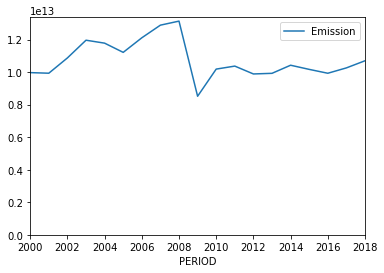

In [57]:
transport_emission_year.plot()
plt.ylim(0)
plt.show()

In [44]:
transport = pd.read_csv(TRANSPORT_DATA_PATH+'transport_final.csv', index_col=0)
transport.head()

,PERIOD,PARTNER,TRANSPORT_MODE,Value,distcap,Emission
0,2000,china,Sea,1377800,7970,153734924000
1,2000,united states,Sea,6292943,6222,548165678844
2,2000,andorra,Sea,2,952,26656
3,2000,united arab emirates,Sea,400621,5159,28935252346
4,2000,anguilla,Sea,4,6876,385056


In [45]:
transport = pd.pivot_table(transport, index=['PARTNER', 'distcap' ,'PERIOD'], columns='TRANSPORT_MODE', values='Value').fillna(value=0)

In [46]:
transport['Sum'] = transport['Air'] + transport['Road'] + transport['Sea']
for col in transport.columns:
    transport[col] /= transport['Sum']
    
transport.head(10)

TRANSPORT_MODE                   Air      Road       Sea  Sum
PARTNER     distcap PERIOD                                   
afghanistan 5416    2000    0.000000  1.000000  0.000000  1.0
                    2001    0.000000  1.000000  0.000000  1.0
                    2002    0.000000  1.000000  0.000000  1.0
                    2003    0.000000  1.000000  0.000000  1.0
                    2004    0.003711  0.931354  0.064935  1.0
                    2005    0.000000  0.932249  0.067751  1.0
                    2006    0.000000  0.882736  0.117264  1.0
                    2007    0.002688  0.983871  0.013441  1.0
                    2008    0.000000  0.968191  0.031809  1.0
                    2009    0.022222  0.966667  0.011111  1.0

In [47]:
transport['emissions_per_kmtons'] = transport['Air'] * emissions['Air'] + transport['Sea'] * emissions['Sea'] + transport['Road'] * emissions['Road']

In [48]:
transport = transport.reset_index()
transport = transport.set_index(['PARTNER', 'PERIOD'], drop=True)
transport

TRANSPORT_MODE      distcap       Air      Road       Sea  Sum  \
PARTNER     PERIOD                                               
afghanistan 2000       5416  0.000000  1.000000  0.000000  1.0   
            2001       5416  0.000000  1.000000  0.000000  1.0   
            2002       5416  0.000000  1.000000  0.000000  1.0   
            2003       5416  0.000000  1.000000  0.000000  1.0   
            2004       5416  0.003711  0.931354  0.064935  1.0   
...                     ...       ...       ...       ...  ...   
zimbabwe    2014       8076  0.000283  0.296300  0.703417  1.0   
            2015       8076  0.000052  0.427885  0.572063  1.0   
            2016       8076  0.001759  0.174090  0.824150  1.0   
            2017       8076  0.000064  0.240369  0.759567  1.0   
            2018       8076  0.000530  0.405343  0.594127  1.0   

TRANSPORT_MODE      emissions_per_kmtons  
PARTNER     PERIOD                        
afghanistan 2000               75.000000  
            2001               75.000000  
            2002               75.000000  
            2003               75.000000  
            2004               73.320965  
...                                  ...  
zimbabwe    2014               32.265716  
            2015               40.136290  
            2016               25.808740  
            2017               28.705747  
            2018               39.084383  

[3639 rows x 6 columns]

In [49]:
transport['emission_per_tons'] = transport['emissions_per_kmtons'] * transport['distcap']
transport

TRANSPORT_MODE      distcap       Air      Road       Sea  Sum  \
PARTNER     PERIOD                                               
afghanistan 2000       5416  0.000000  1.000000  0.000000  1.0   
            2001       5416  0.000000  1.000000  0.000000  1.0   
            2002       5416  0.000000  1.000000  0.000000  1.0   
            2003       5416  0.000000  1.000000  0.000000  1.0   
            2004       5416  0.003711  0.931354  0.064935  1.0   
...                     ...       ...       ...       ...  ...   
zimbabwe    2014       8076  0.000283  0.296300  0.703417  1.0   
            2015       8076  0.000052  0.427885  0.572063  1.0   
            2016       8076  0.001759  0.174090  0.824150  1.0   
            2017       8076  0.000064  0.240369  0.759567  1.0   
            2018       8076  0.000530  0.405343  0.594127  1.0   

TRANSPORT_MODE      emissions_per_kmtons  emission_per_tons  
PARTNER     PERIOD                                           
afghanistan 2000               75.000000      406200.000000  
            2001               75.000000      406200.000000  
            2002               75.000000      406200.000000  
            2003               75.000000      406200.000000  
            2004               73.320965      397106.345083  
...                                  ...                ...  
zimbabwe    2014               32.265716      260577.925996  
            2015               40.136290      324140.678264  
            2016               25.808740      208431.381887  
            2017               28.705747      231827.611417  
            2018               39.084383      315645.476071  

[3639 rows x 7 columns]

In [50]:
transport.to_csv(TRANSPORT_DATA_PATH+'transport_per_tons.csv')